In [12]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install yahooquery

Note: you may need to restart the kernel to use updated packages.


In [14]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

from re import search
from yahooquery import Screener

In [15]:
def getRates(ticker_input ,period_input  ,interval_input ):
    print(ticker_input+" "+period_input+" "+interval_input )
    data = yf.download(tickers=ticker_input, period = period_input, interval = interval_input)
    return data["Close"] 

In [16]:
def getPercChange(d):
    x=round(d.head(1),6).values
    y=round(d.tail(1),6).values
    perc_chg= np.round( (  (y-x) / abs(x)  ) *100  , 4)
    return perc_chg

In [17]:
def mail2me(pair_text,message_text):
    from email.message import EmailMessage
    import smtplib
    from pretty_html_table import build_table

    sender = "ozukun83@gmail.com"
    recipient = "ozukun83@gmail.com"
    message = "Crypto Info all"

    password = input("Type your password and press enter: ")
    
    email = EmailMessage()
    email["From"] = sender
    email["To"] = recipient
    email["Subject"] = "Crypto Rates Python!"+"  "+pair_text
    email.set_content(message_text)

    
    
    smtp = smtplib.SMTP_SSL("smtp.gmail.com")
    smtp.login(sender, password)
    smtp.sendmail(sender, recipient, email.as_string())
    smtp.quit()
    print("Mail succeed !!")

In [18]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=10)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

for cp in getCryptoPairs():
    print(cp)

BTC-USD
ETH-USD
BNB-USD
XRP-USD
BUSD-USD
DOGE-USD
ADA-USD
MATIC-USD


In [20]:
Crypto_Pairs=["BTC-USD","ETH-USD"]

message_input=""
final_message=""
for cp in Crypto_Pairs:
    print(cp)
    df_tmp=getRates(cp,  '3mo',  '1h')
    message_input=cp+"   First: "+str( round( df_tmp.head(1)[0] ,6 ) )+"  "+"Last: "+str( round(df_tmp.tail(1)[0] ,6)  )
    df3mo=getRates(cp,  '3mo',  '1h')
    message_input0=cp+"  '3mo',  '1h' CHANGE % " +str( getPercChange(df3mo)[0])
    
    df1mo=getRates(cp,  '1mo',  '1h')
    message_input1=cp+"  '1mo',  '1h' CHANGE % " +str( getPercChange(df1mo)[0])
    
    dfwk=getRates(cp,'1wk',  '1h')
    message_input2=cp+"  '1wk',  '1h' CHANGE % " +str( getPercChange(dfwk)[0])
    
    message_input=message_input+"\n"+message_input0+"\n"+message_input1+"\n"+message_input2+"\n"+"\n"
    final_message=final_message+message_input
    print(final_message)
    
    
#mail2me("All Crypto Pairs",final_message) 

BTC-USD
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD   First: 19042.904297  Last: 16706.873047
BTC-USD  '3mo',  '1h' CHANGE % -12.2672
BTC-USD  '1mo',  '1h' CHANGE % -2.2297
BTC-USD  '1wk',  '1h' CHANGE % -1.2603


ETH-USD
ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD   First: 19042.904297  Last: 16706.873047
BTC-USD  '3mo',  '1h' CHANGE % -12.2672
BTC-USD  '1mo',  '1h' CHANGE % -2.2297
BTC-USD  '1wk

In [21]:
def getRatesTable(*args):
    df_table = pd.DataFrame()
    for cp in args:
        df10yr=getRates(cp, '10y',  '1d')
        df5yr=getRates(cp,  '5y',  '1d')
        df3yr=getRates(cp,  '3y',  '1d')
        df1yr=getRates(cp,  '1y',  '1d')
        df3mo=getRates(cp,  '3mo',  '1h')
        df1mo=getRates(cp,  '1mo',  '1h')
        df1wk=getRates(cp,  '1wk',  '1h')
        df1dy=getRates(cp,  '1dy',  '1h')
        new_row = pd.Series(data={
                                   'Crypto_Pair':cp,
                                   '10yr_d_CHG%':getPercChange(df10yr)[0],
                                   '5yr_d_CHG%':getPercChange(df5yr)[0],
                                   '3yr_d_CHG%':getPercChange(df3yr)[0],
                                   '1yr_d_CHG%':getPercChange(df1yr)[0], 
                                   '3mo_h_CHG%':getPercChange(df3mo)[0], 
                                   '1mo_h_CHG%':getPercChange(df1mo)[0] ,
                                   '1wk_h_CHG%':getPercChange(df1wk)[0],
                                   '1dy_h_CHG%':getPercChange(df1dy)[0], 
                                 } 
                           )
        
        df_table = df_table.append(new_row, ignore_index=True)
    return df_table

#--------------------------------------------------------------------


Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

dfx=getRatesTable(*Crypto_Pairs)

dfx



BTC-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 complete

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


[*********************100%***********************]  1 of 1 completed
XRP-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
XRP-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
XRP-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
XRP-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
ADA-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 3mo 1

,Crypto_Pair,10yr_d_CHG%,5yr_d_CHG%,3yr_d_CHG%,1yr_d_CHG%,3mo_h_CHG%,1mo_h_CHG%,1wk_h_CHG%,1dy_h_CHG%
0,BTC-USD,3553.1009,11.5122,139.1660,-64.7127,-12.2672,-2.2297,-1.2603,0.6188
1,ETH-USD,278.6817,37.3890,853.7142,-68.2698,-4.7860,-6.0084,-0.9553,1.3928
2,ALGO-USD,-94.3531,-94.3531,-15.3322,-89.2009,-48.9605,-26.0618,5.3822,2.3148
3,SOL-USD,1086.0765,1086.0765,1086.0765,-93.6047,-64.8083,-17.7618,-0.2199,13.8113
4,LUNC-USD,-99.9879,-99.9879,-99.9248,-99.9998,-41.5441,-12.1547,-1.2422,6.0000
5,ROSE-USD,-6.3330,-6.3330,-6.3330,-91.3960,-38.7122,-25.2507,-1.7547,2.9642
6,SHIB-USD,inf,inf,inf,-76.4706,-27.2727,-11.1111,0.0000,0.0000
7,XRP-USD,60.3868,-85.9397,85.5012,-59.3977,-22.2897,-11.9721,-4.6129,3.2993
8,ADA-USD,692.3658,-67.5465,675.4786,-81.5636,-39.4768,-20.4833,-4.2705,2.0312


In [37]:
def mail2me_v2(df,mail_subject,message_text):
    
    from email.mime.text import MIMEText
    from email.mime.application import MIMEApplication
    from email.mime.multipart import MIMEMultipart
    from smtplib import SMTP
    import smtplib
    import sys


    recipients = ['ozukun83@gmail.com'] 
    emaillist = [elem.strip().split(',') for elem in recipients]
    msg = MIMEMultipart()
    msg['Subject'] = mail_subject
    msg['From'] = 'ozukun83@gmail.com'

    password = input("Type your password and press enter: ")
    

    html = """\
    <html>
      <head></head>
      <body>
        {0}
      </body>
    </html>
    """.format(df.to_html())

    part1 = MIMEText(html, 'html')
    msg.attach(part1)
    body = message_text
    body = MIMEText(body) # convert the body to a MIME compatible string
    msg.attach(body)

    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls()
    server.ehlo()
    server.login("ozukun83@gmail.com",password)
    server.sendmail(msg['From'], emaillist , msg.as_string())
    print("Mail succeed !!")
    
#---------------------------------------------------------------------------
#mail2me_v2(dfx,"Crypto Rate changes","")

In [41]:
# moving average
def get_ma(prices, rate):
    return prices.rolling(rate).mean()



def get_bollinger_bands(prices, rate=7):
    sma = get_ma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down

#---------------------------------------------------------------


df_tmp_f = pd.DataFrame()
final_text=""
Crypto_Pairs=["ALGO-USD","LUNC-USD"]


for cp in Crypto_Pairs:

    df_tmp_0 = pd.DataFrame(getRates(cp,  '1y',  '1d'))

    bollinger_up, bollinger_down = get_bollinger_bands(df_tmp_0)


    df_tmp = pd.DataFrame(data=np.column_stack((df_tmp_0.values,bollinger_up,bollinger_down)),columns=['Price','Bol_Up','Bol_Down'])
    df_tmp.insert(0,'Crypto_Pair',cp)
    df_tmp.index=df_tmp_0.index


    display( df_tmp.iloc[-7:] )
    x=round( df_tmp["Bol_Up"].iloc[-7:].mean() ,6 )
    
    print("Bol_Up__Mean_for_last_7days   : " + str( x ) )
    x1="Bol_Up__Mean_for_last_7days   : " + str( x ) 
    
    y=round( df_tmp["Bol_Down"].iloc[-7:].mean() ,6 )
    print("Bol_Down__Mean_for_last_7days : " + str( y ) )
    
    x1="Bol_Up__Mean_for_last_7days   : " + str( x )
    y1="Bol_Down__Mean_for_last_7days : " + str( y )
    
    df_tmp_f = df_tmp_f.append(df_tmp.iloc[-7:])
    final_text=final_text+"\n"+cp+"\n"+str(x1)+"\n"+str(y1)
#---------------------------------------------------------------------------
#mail2me_v2(df_tmp_f,"Crypto Bollinger bands",final_text)

ALGO-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down
Date,,,,
2022-12-27,ALGO-USD,0.169975,0.174292,0.165564
2022-12-28,ALGO-USD,0.167241,0.173655,0.164876
2022-12-29,ALGO-USD,0.165151,0.173034,0.163607
2022-12-30,ALGO-USD,0.169008,0.172661,0.163662
2022-12-31,ALGO-USD,0.172818,0.174522,0.163069
2023-01-01,ALGO-USD,0.177466,0.178478,0.162426
2023-01-02,ALGO-USD,0.181335,0.183408,0.160305


Bol_Up__Mean_for_last_7days   : 0.175721
Bol_Down__Mean_for_last_7days : 0.163358
LUNC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


,Crypto_Pair,Price,Bol_Up,Bol_Down
Date,,,,
2022-12-27,LUNC-USD,0.000173,0.000176,0.000119
2022-12-28,LUNC-USD,0.000148,0.000173,0.000127
2022-12-29,LUNC-USD,0.000150,0.000172,0.000132
2022-12-30,LUNC-USD,0.000143,0.000172,0.000133
2022-12-31,LUNC-USD,0.000145,0.000172,0.000133
2023-01-01,LUNC-USD,0.000150,0.000172,0.000134
2023-01-02,LUNC-USD,0.000160,0.000171,0.000134


Bol_Up__Mean_for_last_7days   : 0.000172
Bol_Down__Mean_for_last_7days : 0.00013


Type your password and press enter:  o m h c a p w m m w u d e o e u


Mail succeed !!


In [23]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def getLine(df_input):
    x = df_input.index
    y = df_input.values
    fig = go.Figure(data=go.Scatter(x = x, y = y))
    fig.show()

ETH-USD 1d 1h
[*********************100%***********************]  1 of 1 completed


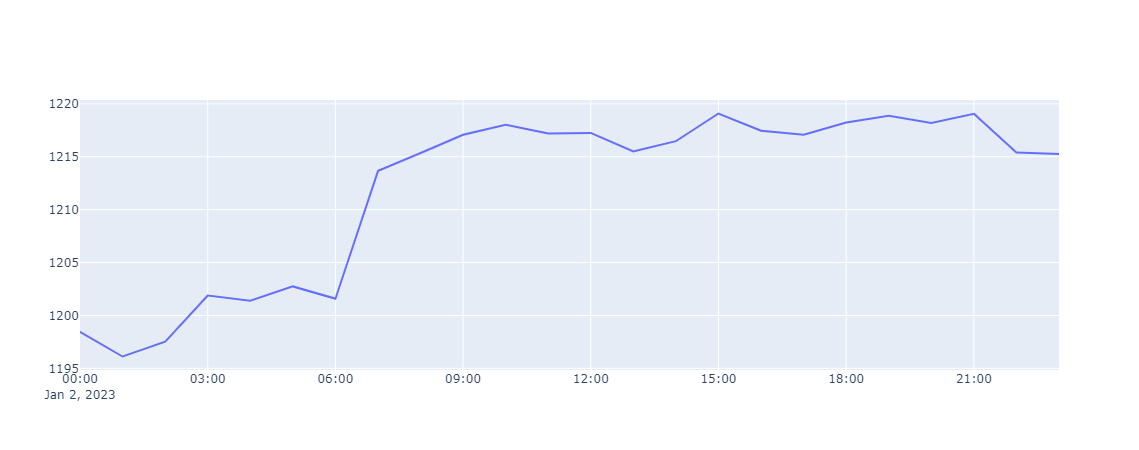

ETH-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed


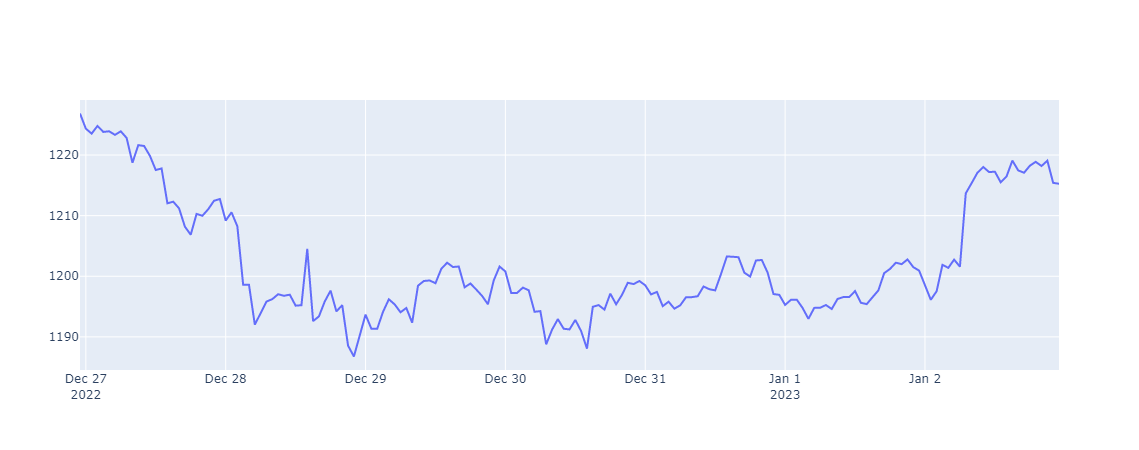

ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed


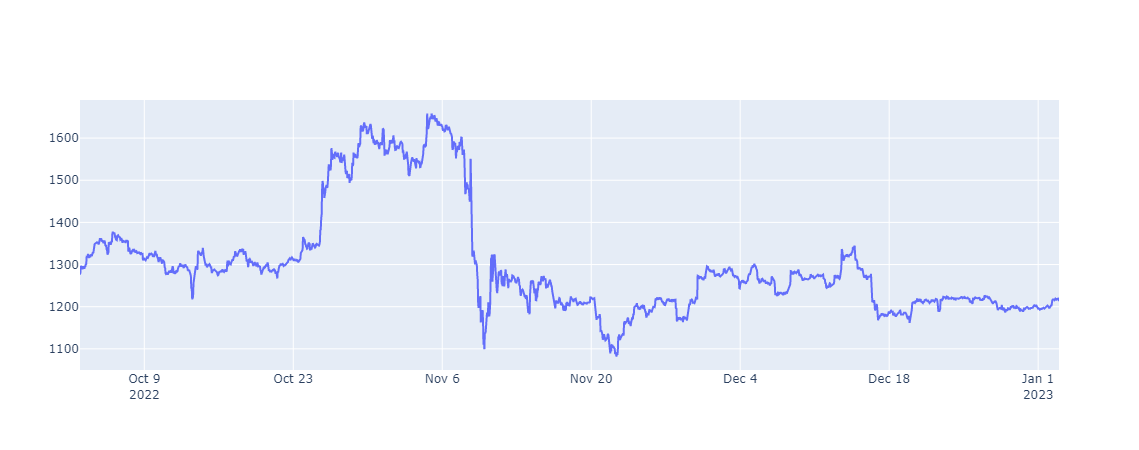

ETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed


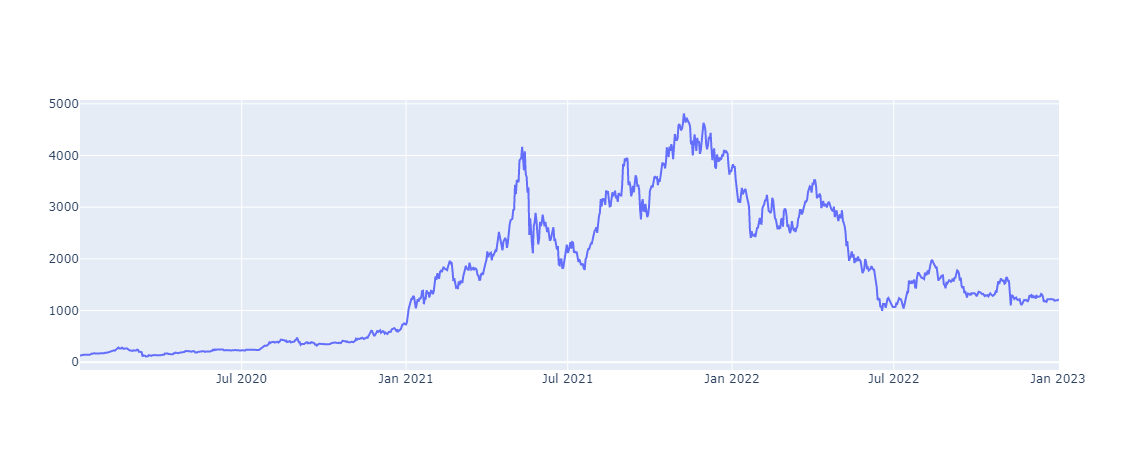

In [24]:
( getLine(getRates('ETH-USD',  '1d',  '1h')) )
( getLine(getRates('ETH-USD',  '1wk',  '1h')) )
( getLine(getRates('ETH-USD',  '3mo',  '1h')) )
( getLine(getRates('ETH-USD',  '3y',  '1d')) )